**ESTE NOTEBOOK ES NECESARIO EJECUTARLO CON LA GPU ACTIVADA**

# Predicción de las pymes zombis en España

## IMPORTACIÓN DE LAS LIBRERÍAS

In [1]:
import math
import os
import itertools
import scipy
import random
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm
from PIL import Image

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

%matplotlib inline

## COMPRENSIÓN DE LOS DATOS: SEGUNDA PARTE

In [2]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 870 kB/s            


Se cargan las partidas contables extraídas desde SABI para las pymes zombis y no zombis en dos dataframes diferentes

**CAMBIAR LAS RUTAS SI SE EJECUTAN EN LOCAL**

In [3]:
sme_zombies = pd.read_excel('../input/variables/pymes_zombis_variables.xlsx', "variables")
sme_no_zombies = pd.read_excel('../input/variables/pymes_no_zombis_variables.xlsx', "variables")

In [4]:
print("Pymes zombis:", sme_zombies.shape[0])
print("Pymes no zombis:",sme_no_zombies.shape[0])
sme_zombies.head()

Pymes zombis: 753
Pymes no zombis: 8451


,Código NIF,Nombre,Forma jurídica,Código primario CNAE 2009,inmov_intangible 2017,inmov_material 2017,deudas_comerciales_no_corrientes 2017,activo_no_corriente 2017,existencias 2017,deudores_comerciales 2017,...,otros_ingresos_expl 2017,deterioro_res_enaj 2017,dif_neg_comb 2017,otros_resultados_expl 2017,resultado_explotacion 2017,gastos_financieros 2017,ebitda 2017,ebit 2017,resultado_ejercicio 2017,Fecha constitución
0,A02021574,HOTELES DE LA MANCHA SA,Sociedad anonima,5510,23147.09,1737321.32,n.d.,3013739.86,30018.51,47907.34,...,12270.9,n.d.,n.d.,-11647.8,-119563.75,-8429.18,66581.16,-119563.75,-95980.31,1984-08-07
1,A02113066,HOTEL YESTE SA,Sociedad anonima,5510,86.28,443466.45,n.d.,465775.77,55125.41,470.68,...,n.d.,n.d.,n.d.,520.94,13132.11,-51.1,31182.19,13132.11,9810.76,1989-11-25
2,A03358744,TORREVIEJA HOTELES SA,Sociedad anonima,5510,18.44,871050.04,n.d.,926673.84,n.d.,114797.28,...,77800.09,n.d.,n.d.,-15256.66,-64885.61,-6222.31,-40710.26,-64885.61,-71419.51,1989-07-14
3,A03462272,MAESTRAL SA,Sociedad anonima,5610,9000,1002370,n.d.,1341352,98705,663232,...,3853,n.d.,n.d.,-293,-438237.00,-19913,-308992.00,-438237.00,-343495,1989-10-20
4,A04102547,EJIDO HOTEL SA,Sociedad anonima,5510,n.d.,1631012.89,n.d.,1682481.02,18965.57,77694.58,...,24000,n.d.,n.d.,-9640.91,9129.98,-34394.59,91746.12,9129.98,-21329.82,1988-12-21


Se define la función ***calculateNdDict(df):*** que devuelve un diccionario con la cuenta de los registros con valor n.d. para cada columna del dataframe

In [5]:
def calculateNdDict(df):
    nd_dict = {}
    for column in df.columns:
        nd_dict[column] = df.loc[df[column] == 'n.d.'].shape[0]
    return nd_dict

In [6]:
nd_z_dict = calculateNdDict(sme_zombies)
nd_no_z_dict = calculateNdDict(sme_no_zombies)

nd_z = sorted(nd_z_dict.items(), key=lambda x: x[1], reverse=True)[:10]
nd_no_z = sorted(nd_no_z_dict.items(), key=lambda x: x[1], reverse=True)[:10]

A continuación se muestran las diez partidas que mayor número de registros n.d. presentan entre las pymes zombis y no zombis

In [7]:
def addLabels(axes,x,y):
    for i in range(len(x)):
        axes.text(i, y[i], y[i], ha='center')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


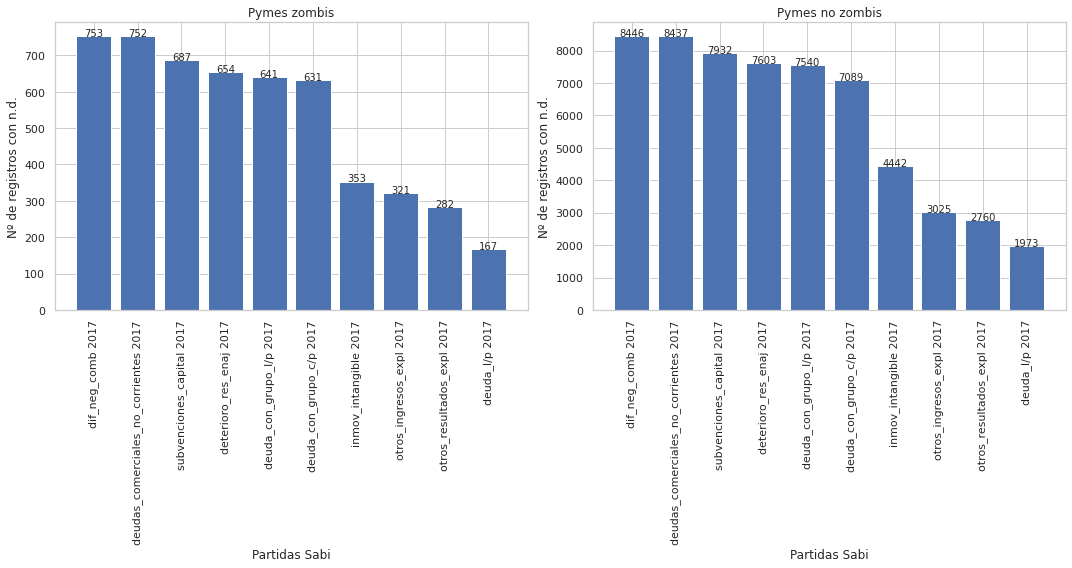

In [8]:
## Declaramos valores para el eje x e y
x1, y1 = [i[0] for i in nd_z], [i[1] for i in nd_z]
x2, y2 = [i[0] for i in nd_no_z], [i[1] for i in nd_no_z]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].bar(x1, y1)
axes[0].set_ylabel('Nº de registros con n.d.')
axes[0].set_xlabel('Partidas Sabi')
axes[0].set_title("Pymes zombis")
axes[0].set_xticklabels(np.array(x1), rotation = 'vertical')
addLabels(axes[0],x1,y1)


axes[1].bar(x2, y2)
axes[1].set_ylabel('Nº de registros con n.d.')
axes[1].set_xlabel('Partidas Sabi')
axes[1].set_title("Pymes no zombis")
axes[1].set_xticklabels(np.array(x1), rotation = 'vertical')
addLabels(axes[1],x2,y2)

fig.tight_layout()

plt.show()

## PREPARCIÓN DE LOS DATOS

### TRATAMIENTO DE LOS DATOS FALTANTES

Se elimina las dos columnas que mayor número de datos faltantes presentan: diferencia negativa en combinaciones de negocios y deudas comerciales no corrientes

In [9]:
sme_zombies.drop('dif_neg_comb 2017', axis=1, inplace=True)
sme_no_zombies.drop('dif_neg_comb 2017', axis=1, inplace=True)
print("Pymes zombis restantes:", sme_zombies.shape[0])
print("Pymes no zombis restantes:",sme_no_zombies.shape[0])

Pymes zombis restantes: 753
Pymes no zombis restantes: 8451


In [10]:
sme_zombies.drop('deudas_comerciales_no_corrientes 2017', axis=1, inplace=True)
sme_no_zombies.drop('deudas_comerciales_no_corrientes 2017', axis=1, inplace=True)
print("Pymes zombis restantes:", sme_zombies.shape[0])
print("Pymes no zombis restantes:",sme_no_zombies.shape[0])

Pymes zombis restantes: 753
Pymes no zombis restantes: 8451


Se eliminan todas las pymes que no presentan la cifra de negocios en el año 2017

In [11]:
print("zombis con cifra negocios a n.d.:", sme_zombies.loc[sme_zombies['cifra_negocios 2017'] == 'n.d.'].shape[0])
print("no_zombis con cifra negocios a n.d.:", sme_no_zombies.loc[sme_no_zombies['cifra_negocios 2017'] == 'n.d.'].shape[0])
sme_zombies.drop(sme_zombies.loc[sme_zombies['cifra_negocios 2017'] == 'n.d.'].index, inplace=True)
sme_no_zombies.drop(sme_no_zombies.loc[sme_no_zombies['cifra_negocios 2017'] == 'n.d.'].index, inplace=True)
print("Pymes zombis restantes:", sme_zombies.shape[0])
print("Pymes no zombis restantes:",sme_no_zombies.shape[0])

zombis con cifra negocios a n.d.: 30
no_zombis con cifra negocios a n.d.: 40
Pymes zombis restantes: 723
Pymes no zombis restantes: 8411


Se procede a eliminar aquellas empresas que presentan datos faltantes en sus gastos financieros y en todas sus deudas remuneradas 

In [12]:
sme_zombies.drop(sme_zombies[sme_zombies['gastos_financieros 2017'] == 'n.d.'].index, inplace=True)
sme_no_zombies.drop(sme_no_zombies[sme_no_zombies['gastos_financieros 2017'] == 'n.d.'].index, inplace=True)
print("Pymes zombis restantes:", sme_zombies.shape[0])
print("Pymes no zombis restantes:",sme_no_zombies.shape[0])

Pymes zombis restantes: 658
Pymes no zombis restantes: 7808


In [13]:
sme_zombies.drop(sme_zombies[(sme_zombies['deuda_con_grupo_l/p 2017'] == 'n.d.') &
                            (sme_zombies['deuda_con_grupo_c/p 2017'] == 'n.d.') &
                            (sme_zombies['deuda_l/p 2017'] == 'n.d.') &
                            (sme_zombies['deuda_c/p 2017'] == 'n.d.')].index, inplace=True)

sme_no_zombies.drop(sme_no_zombies[(sme_no_zombies['deuda_con_grupo_l/p 2017'] == 'n.d.') &
                                   (sme_no_zombies['deuda_con_grupo_c/p 2017'] == 'n.d.') &
                                   (sme_no_zombies['deuda_l/p 2017'] == 'n.d.') &
                                   (sme_no_zombies['deuda_c/p 2017'] == 'n.d.')].index, inplace=True)

print("Pymes zombis restantes:", sme_zombies.shape[0])
print("Pymes no zombis restantes:",sme_no_zombies.shape[0])

Pymes zombis restantes: 648
Pymes no zombis restantes: 7354


Se imputan el resto de valores n.d. de ambas empresas por un 0

In [14]:
sme_zombies = sme_zombies.replace('n.d.', 0)
sme_no_zombies = sme_no_zombies.replace('n.d.', 0)
sme_zombies.reset_index(drop=True, inplace=True)
sme_no_zombies.reset_index(drop=True, inplace=True)

### ELABORACIÓN DE RATIOS PROPIAS

Para facilitar el cálculo de las ratios, se determinan las variables que se mencionan en la tabla A4 de la memoria

In [15]:
sme_zombies['activo_total 2017'] = sme_zombies['activo_corriente 2017'] + sme_zombies['activo_no_corriente 2017']
sme_zombies['pasivo_total 2017'] = sme_zombies['pasivo_corriente 2017'] + sme_zombies['pasivo_no_corriente 2017']
sme_zombies['drt 2017'] = sme_zombies['deuda_l/p 2017'] + sme_zombies['deuda_con_grupo_l/p 2017'] + sme_zombies['deuda_c/p 2017'] + sme_zombies['deuda_con_grupo_c/p 2017']
sme_zombies['activo_funcional 2017'] = sme_zombies['inmov_intangible 2017'] + sme_zombies['inmov_material 2017'] + sme_zombies['existencias 2017'] + sme_zombies['deudores_comerciales 2017'] + sme_zombies['efectivo 2017']
sme_zombies['subvenciones 2017'] = sme_zombies['subvenciones_capital 2017'] + sme_zombies['otros_ingresos_expl 2017']
sme_zombies['resultado_explotacion_ajustado 2017'] = sme_zombies['resultado_explotacion 2017'] - sme_zombies['deterioro_res_enaj 2017'] - sme_zombies['otros_resultados_expl 2017']

In [16]:
sme_no_zombies['activo_total 2017'] = sme_no_zombies['activo_corriente 2017'] + sme_no_zombies['activo_no_corriente 2017']
sme_no_zombies['pasivo_total 2017'] = sme_no_zombies['pasivo_corriente 2017'] + sme_no_zombies['pasivo_no_corriente 2017']
sme_no_zombies['drt 2017'] = sme_no_zombies['deuda_l/p 2017'] + sme_no_zombies['deuda_con_grupo_l/p 2017'] + sme_no_zombies['deuda_c/p 2017'] + sme_no_zombies['deuda_con_grupo_c/p 2017']
sme_no_zombies['activo_funcional 2017'] = sme_no_zombies['inmov_intangible 2017'] + sme_no_zombies['inmov_material 2017'] + sme_no_zombies['existencias 2017'] + sme_no_zombies['deudores_comerciales 2017'] + sme_no_zombies['efectivo 2017']
sme_no_zombies['subvenciones 2017'] = sme_no_zombies['subvenciones_capital 2017'] + sme_no_zombies['otros_ingresos_expl 2017']
sme_no_zombies['resultado_explotacion_ajustado 2017'] = sme_no_zombies['resultado_explotacion 2017'] - sme_no_zombies['deterioro_res_enaj 2017'] - sme_no_zombies['otros_resultados_expl 2017']

Se crean las listas necesarias con el nombre de las distintas variables a calcular

In [17]:
normal_ratios = ['r_end1','r_end2','roa','roa_expl','r_rent_negc','roe', 'ros','r_sub1','r_sub2','r_sub3','r_csd','r_solv']
icr_ratios = ['icr_1','icr_2']
log_vars = ['log_activos','log_pasivos','log_drt','log_cifra_negocios']
age_var = ['edad']

Se definen 2 funciones que facilitarán el cálculo de las distintas variables para la predicción de zombis
- ***calculatePersonalVars(num, column_name, den=0):*** función que devuelve el resultado de la variable dependiendo que columna sé está calculando
- ***calculateAge(from_date):*** función que devuelve la edad de la empresa en años como 2017 - la fecha de constitución

In [18]:
def calculatePersonalVars(num, column_name, den=0):
    if column_name in normal_ratios: return num/den
    if column_name in icr_ratios: return num/abs(den)
    if column_name in log_vars: return math.log(num,10)

def calculateAge(from_date):
    end_date = datetime(2017,12,31)
    
    if type(from_date) == str:
        date = from_date.split('/')
        from_date = datetime(int(date[2]),int(date[1]),int(date[0]))
    
    if from_date.year % 4 == 0:
        return ((end_date-from_date).days/366)
    else:
        return ((end_date-from_date).days/365)

Se crean dos dataframes diferentes que permitirán la exploración inicial de las variables para las empresas zombis y no zombis

In [19]:
z_vars = pd.DataFrame(columns=normal_ratios+icr_ratios+log_vars+age_var)
nz_vars = pd.DataFrame(columns=normal_ratios+icr_ratios+log_vars+age_var)

Cálculo de las variables de la tabla 8 de la memoria para las zombis y no zombis. Además se asigna la etiqueta 1 para las pymes zombis y 0 para las no zombis

In [20]:
z_vars['r_end1'] = sme_zombies[['pasivo_total 2017', 'activo_total 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_end1',row[1]), axis=1)
z_vars['r_end2'] = sme_zombies[['drt 2017', 'activo_total 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_end2',row[1]), axis=1)
z_vars['roa'] = sme_zombies[['ebit 2017', 'activo_total 2017']].apply(lambda row: calculatePersonalVars(row[0],'roa',row[1]), axis=1)
z_vars['roa_expl'] = sme_zombies[['resultado_explotacion_ajustado 2017', 'activo_funcional 2017']].apply(lambda row: calculatePersonalVars(row[0],'roa_expl',row[1]), axis=1)
z_vars['r_rent_negc'] = sme_zombies[['ebitda 2017', 'activo_total 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_rent_negc',row[1]), axis=1)
z_vars['roe'] = sme_zombies[['resultado_ejercicio 2017', 'patrimonio_neto 2017']].apply(lambda row: calculatePersonalVars(row[0],'roe',row[1]), axis=1)
z_vars['ros'] = sme_zombies[['ebit 2017', 'cifra_negocios 2017']].apply(lambda row: calculatePersonalVars(row[0],'ros',row[1]), axis=1)
z_vars['r_sub1'] = sme_zombies[['subvenciones 2017', 'cifra_negocios 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_sub1',row[1]), axis=1)
z_vars['r_sub2'] = sme_zombies[['subvenciones 2017', 'activo_total 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_sub2',row[1]), axis=1)
z_vars['r_sub3'] = sme_zombies[['subvenciones 2017', 'resultado_ejercicio 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_sub3',row[1]), axis=1)
z_vars['r_csd'] = sme_zombies[['ebitda 2017', 'drt 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_csd',row[1]), axis=1)
z_vars['r_solv'] = sme_zombies[['activo_total 2017', 'pasivo_total 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_solv',row[1]), axis=1)
z_vars['icr_1'] = sme_zombies[['ebit 2017', 'gastos_financieros 2017']].apply(lambda row: calculatePersonalVars(row[0],'icr_1',row[1]), axis=1)
z_vars['icr_2'] = sme_zombies[['ebitda 2017', 'gastos_financieros 2017']].apply(lambda row: calculatePersonalVars(row[0],'icr_2',row[1]), axis=1)
z_vars['log_activos'] = sme_zombies['activo_total 2017'].apply(lambda row: calculatePersonalVars(row,'log_activos'))
z_vars['log_pasivos'] = sme_zombies['pasivo_total 2017'].apply(lambda row: calculatePersonalVars(row,'log_pasivos'))
z_vars['log_drt'] = sme_zombies['drt 2017'].apply(lambda row: calculatePersonalVars(row,'log_drt'))
z_vars['log_cifra_negocios'] = sme_zombies['cifra_negocios 2017'].apply(lambda row: calculatePersonalVars(row,'log_cifra_negocios'))
z_vars['edad'] = sme_zombies['Fecha constitución'].apply(lambda date: calculateAge(date))
z_vars['etiqueta'] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [21]:
z_vars.head()

,r_end1,r_end2,roa,roa_expl,r_rent_negc,roe,ros,r_sub1,r_sub2,r_sub3,r_csd,r_solv,icr_1,icr_2,log_activos,log_pasivos,log_drt,log_cifra_negocios,edad,etiqueta
0,0.783513,0.670432,-0.037340,-0.055731,0.020793,-0.138459,-0.074179,0.007613,0.003832,-0.127848,0.031015,1.276304,-14.184505,7.898889,6.505428,6.399474,6.331783,6.207318,33.330601,1
1,0.640824,0.436990,0.017587,0.024439,0.041760,0.036581,0.022488,0.000000,0.000000,0.000000,0.095563,1.560491,256.988454,610.218982,5.873144,5.679882,5.513615,5.766389,28.117808,1
2,0.341556,0.127092,-0.059229,-0.047842,-0.037161,-0.099011,-0.045334,0.054358,0.071017,-1.089339,-0.292395,2.927779,-10.427897,-6.542628,6.039617,5.573078,5.143734,6.155720,28.484932,1
3,0.954114,0.713115,-0.188774,-0.234995,-0.133101,-3.224548,-0.135233,0.001189,0.001660,-0.011217,-0.186647,1.048093,-22.007583,-15.517099,6.365767,6.345367,6.218927,6.510626,28.216438,1
4,0.510644,0.440711,0.005061,0.010711,0.050858,-0.024162,0.012153,0.031948,0.013304,-1.125185,0.115400,1.958311,0.265448,2.667458,6.256227,5.964345,5.900381,5.875770,28.967213,1


In [22]:
nz_vars['r_end1'] = sme_no_zombies[['pasivo_total 2017', 'activo_total 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_end1',row[1]), axis=1)
nz_vars['r_end2'] = sme_no_zombies[['drt 2017', 'activo_total 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_end2',row[1]), axis=1)
nz_vars['roa'] = sme_no_zombies[['ebit 2017', 'activo_total 2017']].apply(lambda row: calculatePersonalVars(row[0],'roa',row[1]), axis=1)
nz_vars['roa_expl'] = sme_no_zombies[['resultado_explotacion_ajustado 2017', 'activo_funcional 2017']].apply(lambda row: calculatePersonalVars(row[0],'roa_expl',row[1]), axis=1)
nz_vars['r_rent_negc'] = sme_no_zombies[['ebitda 2017', 'activo_total 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_rent_negc',row[1]), axis=1)
nz_vars['roe'] = sme_no_zombies[['resultado_ejercicio 2017', 'patrimonio_neto 2017']].apply(lambda row: calculatePersonalVars(row[0],'roe',row[1]), axis=1)
nz_vars['ros'] = sme_no_zombies[['ebit 2017', 'cifra_negocios 2017']].apply(lambda row: calculatePersonalVars(row[0],'ros',row[1]), axis=1)
nz_vars['r_sub1'] = sme_no_zombies[['subvenciones 2017', 'cifra_negocios 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_sub1',row[1]), axis=1)
nz_vars['r_sub2'] = sme_no_zombies[['subvenciones 2017', 'activo_total 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_sub2',row[1]), axis=1)
nz_vars['r_sub3'] = sme_no_zombies[['subvenciones 2017', 'resultado_ejercicio 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_sub3',row[1]), axis=1)
nz_vars['r_csd'] = sme_no_zombies[['ebitda 2017', 'drt 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_csd',row[1]), axis=1)
nz_vars['r_solv'] = sme_no_zombies[['activo_total 2017', 'pasivo_total 2017']].apply(lambda row: calculatePersonalVars(row[0],'r_solv',row[1]), axis=1)
nz_vars['icr_1'] = sme_no_zombies[['ebit 2017', 'gastos_financieros 2017']].apply(lambda row: calculatePersonalVars(row[0],'icr_1',row[1]), axis=1)
nz_vars['icr_2'] = sme_no_zombies[['ebitda 2017', 'gastos_financieros 2017']].apply(lambda row: calculatePersonalVars(row[0],'icr_2',row[1]), axis=1)
nz_vars['log_activos'] = sme_no_zombies['activo_total 2017'].apply(lambda row: calculatePersonalVars(row,'log_activos'))
nz_vars['log_pasivos'] = sme_no_zombies['pasivo_total 2017'].apply(lambda row: calculatePersonalVars(row,'log_pasivos'))
nz_vars['log_drt'] = sme_no_zombies['drt 2017'].apply(lambda row: calculatePersonalVars(row,'log_drt'))
nz_vars['log_cifra_negocios'] = sme_no_zombies['cifra_negocios 2017'].apply(lambda row: calculatePersonalVars(row,'log_cifra_negocios'))
nz_vars['edad'] = sme_no_zombies['Fecha constitución'].apply(lambda date: calculateAge(date))
nz_vars['etiqueta'] = 0

In [23]:
nz_vars.head()

,r_end1,r_end2,roa,roa_expl,r_rent_negc,roe,ros,r_sub1,r_sub2,r_sub3,r_csd,r_solv,icr_1,icr_2,log_activos,log_pasivos,log_drt,log_cifra_negocios,edad,etiqueta
0,0.162747,0.073197,-0.031035,-0.065031,0.005752,-0.039645,-0.019693,0.025123,0.039593,-1.192836,0.078585,6.144499,-5.807179,1.076320,5.675968,4.887482,4.540463,5.873522,29.005464,0
1,0.719713,0.688276,0.053829,0.416072,0.064551,0.150885,0.151941,0.002636,0.000934,0.022078,0.093787,1.389444,4.043110,4.848474,7.194273,7.051432,7.032036,6.743613,27.572603,0
2,0.597776,0.462294,0.027739,0.028592,0.066957,0.026419,0.064365,0.224397,0.096708,9.100680,0.144836,1.672868,1.620527,3.911636,6.807522,6.584061,6.472441,6.441968,18.879452,0
3,0.426308,0.383452,0.057209,0.057406,0.083842,0.074638,0.111400,0.026532,0.013625,0.318202,0.218651,2.345724,3.956978,5.799105,6.403534,6.033257,5.987245,6.114115,51.438356,0
4,0.207254,0.065025,0.019507,0.069321,0.035292,0.059418,0.087803,0.001661,0.000369,0.007832,0.542737,4.824997,6.608780,11.956515,6.942296,6.258799,5.755377,6.288974,28.021918,0


Se generan las variables estadísticas básicas para las zombis y no zombis. Además, no se escogen las variables logarítmicas para ello sino las variables de las que estas derivan, es decir las no logarítmicas

In [24]:
z_stats = z_vars.copy()
z_stats.drop(['log_activos', 'log_pasivos', 'log_drt', 'log_cifra_negocios', 'etiqueta'], axis=1, inplace=True)
z_stats['activo_total'],z_stats['pasivo_total'],z_stats['drt'],z_stats['cifra_negocios'] = sme_zombies['activo_total 2017'],sme_zombies['pasivo_total 2017'],sme_zombies['drt 2017'],sme_zombies['cifra_negocios 2017']
z_stats.describe()

,r_end1,r_end2,roa,roa_expl,r_rent_negc,roe,ros,r_sub1,r_sub2,r_sub3,r_csd,r_solv,icr_1,icr_2,edad,activo_total,pasivo_total,drt,cifra_negocios
count,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,648.000000,647.000000,648.000000,648.000000,648.000000,648.000000,648.000000,6.480000e+02,6.480000e+02,6.480000e+02,6.480000e+02
mean,1.062193,0.818211,-0.105895,-0.166267,-0.054721,-0.203795,-1.583509,0.041817,0.018363,1.152024,-0.443526,1.919323,645.569141,1399.410532,14.963290,4.381033e+06,3.483907e+06,3.102309e+06,1.400353e+06
std,1.092858,0.985901,0.255861,0.423220,0.260035,3.290017,34.487813,0.240459,0.059066,12.410472,4.997120,4.227469,20923.348791,36733.956741,11.338255,1.407013e+07,1.516917e+07,1.471965e+07,2.051778e+06
min,0.011688,0.000657,-4.077127,-4.051723,-3.978460,-53.572580,-877.393897,0.000000,0.000000,-30.684833,-107.821721,0.083791,-38966.104046,-11109.693578,1.234973,1.834177e+04,1.170131e+04,2.402300e+02,3.000000e+02
25%,0.632972,0.402434,-0.120365,-0.148982,-0.070332,-0.151187,-0.133338,0.000000,0.000000,-0.119103,-0.110118,0.903872,-21.763868,-10.049287,5.786885,3.922423e+05,3.444342e+05,2.162211e+05,5.550750e+05
50%,0.883847,0.675345,-0.032580,-0.041016,0.006878,-0.002532,-0.035842,0.001767,0.001695,0.000000,0.010990,1.131418,-4.063219,0.895025,13.118852,9.003855e+05,7.387040e+05,5.486942e+05,8.703307e+05
75%,1.106351,0.923364,0.003947,0.002939,0.038358,0.119055,0.003795,0.012644,0.014552,-0.000000,0.066866,1.579913,0.636818,5.631384,20.980874,2.961320e+06,2.073523e+06,1.594588e+06,1.435008e+06
max,11.934409,9.883200,0.186904,0.270874,0.319871,28.693100,0.226692,4.143855,0.791483,191.139547,5.160211,85.559882,530508.000000,934780.000000,97.147541,2.363430e+08,2.684114e+08,2.683765e+08,3.296100e+07


In [25]:
nz_stats = nz_vars.copy()
nz_stats.drop(['log_activos', 'log_pasivos', 'log_drt', 'log_cifra_negocios', 'etiqueta'], axis=1, inplace=True)
nz_stats['activo_total'],nz_stats['pasivo_total'],nz_stats['drt'],nz_stats['cifra_negocios'] = sme_no_zombies['activo_total 2017'],sme_no_zombies['pasivo_total 2017'],sme_no_zombies['drt 2017'],sme_no_zombies['cifra_negocios 2017']
nz_stats.describe()

,r_end1,r_end2,roa,roa_expl,r_rent_negc,roe,ros,r_sub1,r_sub2,r_sub3,r_csd,r_solv,icr_1,icr_2,edad,activo_total,pasivo_total,drt,cifra_negocios
count,7354.000000,7.354000e+03,7354.000000,7354.000000,7354.000000,7354.000000,7354.000000,7354.000000,7354.000000,7354.000000,7.354000e+03,7354.000000,7.354000e+03,7.354000e+03,7354.000000,7.354000e+03,7.354000e+03,7.354000e+03,7.354000e+03
mean,0.697258,4.272386e-01,0.092267,0.136880,0.141627,1.702858,0.076334,0.120815,0.023787,27.142267,7.449889e+02,7.687228,2.863371e+04,3.036244e+04,16.505494,3.983599e+06,1.921624e+06,1.521299e+06,2.275594e+06
std,2.343288,2.078961e+00,0.304529,0.583062,0.309500,112.183427,1.182514,4.374593,0.093490,2327.780204,6.050859e+04,433.996814,1.879679e+06,1.886307e+06,12.542986,1.776353e+07,7.335511e+06,6.932455e+06,3.758437e+06
min,0.000027,1.305116e-07,-3.062525,-24.076514,-3.043666,-217.481109,-43.348389,0.000000,0.000000,-4193.195573,-4.676501e+03,0.005103,-2.915572e+06,-1.784944e+06,1.218579,7.898100e+02,1.010000e+00,2.000000e-02,1.696970e+03
25%,0.407654,1.508213e-01,0.026422,0.029172,0.062393,0.033583,0.015849,0.000000,0.000000,0.000000,1.407245e-01,1.168615,2.384453e+00,5.471497e+00,5.923497,3.407544e+05,2.112445e+05,7.718735e+04,7.571449e+05
50%,0.640587,3.438240e-01,0.066517,0.081777,0.116334,0.126710,0.048468,0.002862,0.003346,0.021555,3.472394e-01,1.561069,8.094872e+00,1.493763e+01,14.587671,8.428644e+05,4.592043e+05,2.434616e+05,1.215492e+06
75%,0.855714,5.754896e-01,0.139729,0.186352,0.201027,0.319175,0.114764,0.014449,0.019363,0.295436,1.020956e+00,2.453058,2.699323e+01,4.202718e+01,23.539726,2.589331e+06,1.211427e+06,7.764727e+05,2.361089e+06
max,195.944062,1.736475e+02,21.652727,24.072549,21.764538,9515.473166,68.432353,311.358828,3.300716,199569.400000,5.188168e+06,37217.663366,1.600748e+08,1.601821e+08,129.341530,9.759910e+08,2.805173e+08,2.750390e+08,1.349035e+08


Se proceden a juntar todas las ratios de las empresas en un mismo dataframe, que nos facilitirá la creación de las imagenes para la CNN

In [26]:
ratios = pd.concat([z_vars, nz_vars])
print("Zombis:", ratios.loc[ratios['etiqueta'] == 1].shape[0])
print("No Zombis:", ratios.loc[ratios['etiqueta'] == 0].shape[0])

Zombis: 648
No Zombis: 7354


Además, como puede observarse una empresa zombi presenta el valor NaN en la ratio r_sub3. Así, se procede con la eliminación de dicha empresa de la muestra que nos deja con un número final de 647 zombis.

In [27]:
print(ratios.isnull().sum())

r_end1                0
r_end2                0
roa                   0
roa_expl              0
r_rent_negc           0
roe                   0
ros                   0
r_sub1                0
r_sub2                0
r_sub3                1
r_csd                 0
r_solv                0
icr_1                 0
icr_2                 0
log_activos           0
log_pasivos           0
log_drt               0
log_cifra_negocios    0
edad                  0
etiqueta              0
dtype: int64


In [28]:
ratios = ratios.dropna()
ratios.reset_index(drop=True, inplace=True)
print("Zombis:", ratios.loc[ratios['etiqueta'] == 1].shape[0])
print("No Zombis:", ratios.loc[ratios['etiqueta'] == 0].shape[0])

Zombis: 647
No Zombis: 7354


### GENERACIÓN DE IMÁGENES: solo con las variables iniciales del estudio

En primer lugar, establecemos las siguientes funciones que nos ayudarán para obtener el brillo de un pixel:
- ***getMeanVars(df):*** función que devuelve la media de todas las columnas de un dataframe excepto la última ya que se trata de la etiqueta
- ***getStdVars(df):*** función que devuelve la desviación típica de todas las columnas de un dataframe excepto la última ya que se trata de la etiqueta

In [29]:
def getMeanVars(df):
    all_columns = list(df.describe().columns[:-1])
    return [df[column].mean() for column in all_columns]

def getStdVars(df):
    all_columns = list(df.describe().columns[:-1])
    return [df[column].std() for column in all_columns]

La función ***getImgPixels(sme_vars, mean_vars, std_vars):*** devuelve los pixeles de una imagen cuadrada en un array bidimensional. Además, a dichos pixeles ya se le ha aplicado la ecuación 10 de la memoria.

También se establece  la función ***plotImage(img_arr)*** que permitirá visualizar una imagen dado su array bidimensional de pixeles

In [30]:
def getImgPixels(sme_vars, mean_vars, std_vars):
    dim = math.ceil(math.sqrt(len(sme_vars)))
    img_arr = []
    for i in range(len(mean_vars)):
        pixel_value = ((sme_vars[i]-mean_vars[i])/std_vars[i])*100 + 128
        if pixel_value > 255: pixel_value = 255
        if pixel_value < 0: pixel_value = 0
        img_arr.append(pixel_value)
    
    if len(img_arr) < dim*dim:
        for i in range(dim*dim-len(img_arr)): img_arr.append(0)
    img_arr = np.array(img_arr).reshape(dim,dim)
    return img_arr

def plotImage(img_arr):
    plt.imshow(img_arr, cmap='gray')
    plt.axis('off')

Se visualiza la imagen de una empresa zombi y no zombi

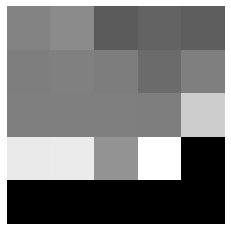

In [31]:
plotImage(getImgPixels(list(ratios.loc[0]), getMeanVars(ratios), getStdVars(ratios)))

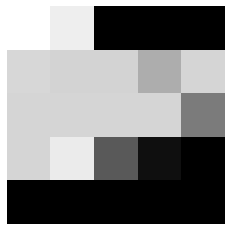

In [32]:
plotImage(getImgPixels(list(ratios.loc[8000]), getMeanVars(ratios), getStdVars(ratios)))

Se definen dos funciones que ayudarán para la generación de distintos datasets a emplear en el estudio:
- ***generateImages(df, dir_path, dir_name, corr=False):*** genera las imágenes en escala de grises para cada empresa del dataframe dado y **LO GUARDA EN LA RUTA:** ***dir_path/dir_name***. Además, devuelve la ruta en donde se han guardado las imágenes.
- ***saveImg_224(img_arr, dir_path, dir_name, file_name, eti):*** función auxiliar que ayuda a la anterior para guardar las imagenes aumentadas a 224x224 pixeles, en dos directorios distintos: zombie y no_zombie

Además, todas las imágenes para las zombis se guardan bajo el nombre: **z(i)** y para las no zombis: **nz(i)**. Donde i es un número entero que corresponde al número de fila del dataframe

In [33]:
def saveImg_224(img_arr, dir_path, dir_name, file_name, eti):
    
    ds_path = dir_path + dir_name
    
    if os.path.isdir(ds_path) is False:
        os.makedirs(ds_path)
    
    if os.path.isdir(ds_path + "/zombie") is False:
        os.makedirs(ds_path + "/zombie")
        os.makedirs(ds_path + "/no_zombie")
    
    z_dir_path = ds_path + "/zombie/"
    nz_dir_path = ds_path + "/no_zombie/"
        
    img_224_pil = np.array(Image.fromarray(img_arr).resize((224, 224), Image.NEAREST))
    img_to_save = Image.fromarray(img_224_pil).convert('L')
    
    if eti == 1:
        img_to_save.save(z_dir_path + file_name + '.png')
    else:
        img_to_save.save(nz_dir_path + file_name + '.png')

def generateImages(df, dir_path, dir_name, corr=False):
    mean_vars, std_vars = getMeanVars(df), getStdVars(df)
    for i in tqdm(range(df.shape[0])):
        sme_ratios = df.loc[i]
        if corr:
            img_arr = getCorrImgPixels(list(sme_ratios)[:-1], mean_vars, std_vars)
        else:
            img_arr = getImgPixels(list(sme_ratios)[:-1], mean_vars, std_vars)
        
        file_name = ''
        if sme_ratios['etiqueta'] == 1:
            file_name = "z"+str(i)
        else:
            file_name = "nz"+str(i)
        saveImg_224(img_arr, dir_path, dir_name, file_name, sme_ratios['etiqueta'])
    return dir_path + dir_name

Guardamos en variable la ruta del dataset **dsa1**. 

**SIN EMBARGO, COMO LOS DATASETS YA SE ENTREGAN FORMADOS NO HACE FALTA LLAMAR AL MÉTODO GENERATEIMAGES() DE NUEVO**. Así, se establece una ruta absoluta hacia el dataset dsa1

**CAMBIAR ESTA RUTA SI SE EJECUTA EN LOCAL**

In [34]:
#path_dsa1 = generateImages(ratios, "./", "dsa1")
path_dsa1 = '../input/dataset/dsa1/dsa1'

### GENERACIÓN DE IMÁGENES: variables iniciales + diferencias con la media

Primero, se genera un nuevo dataframe que contiene todas las variables iniciales y sobre las que se calcularán las diferencias con sus medias

In [35]:
ratios_with_dif = ratios.copy()
eti_column = ratios_with_dif['etiqueta']
ratios_with_dif.drop('etiqueta', axis=1, inplace=True)

distance_mean_columns = ['dm-r_end1','dm-r_end2','dm-roa','dm-roa_expl','dm-r_rent_negc','dm-roe', 'dm-ros','dm-r_sub1','dm-r_sub2',
                         'dm-r_sub3','dm-r_csd','dm-r_solv','dm-icr_1','dm-icr_2','dm-log_activos','dm-log_pasivos','dm-log_drt',
                         'dm-log_cifra_negocios','dm-edad']

for ratio_column,distance_mean_column in zip(list(ratios.describe().columns),distance_mean_columns):
    ratios_with_dif[distance_mean_column] = ratios_with_dif[ratio_column].mean() - ratios_with_dif[ratio_column] 

ratios_with_dif['etiqueta'] = eti_column
ratios_with_dif.head()

,r_end1,r_end2,roa,roa_expl,r_rent_negc,roe,ros,r_sub1,r_sub2,r_sub3,...,dm-r_csd,dm-r_solv,dm-icr_1,dm-icr_2,dm-log_activos,dm-log_pasivos,dm-log_drt,dm-log_cifra_negocios,dm-edad,etiqueta
0,0.783513,0.670432,-0.037340,-0.055731,0.020793,-0.138459,-0.074179,0.007613,0.003832,-0.127848,...,684.678548,5.944657,26384.716263,28012.619131,-0.499925,-0.641960,-0.927174,-0.080223,-16.948890,1
1,0.640824,0.436990,0.017587,0.024439,0.041760,0.036581,0.022488,0.000000,0.000000,0.000000,...,684.614000,5.660469,26113.543303,27410.299038,0.132360,0.077632,-0.109006,0.360706,-11.736097,1
2,0.341556,0.127092,-0.059229,-0.047842,-0.037161,-0.099011,-0.045334,0.054358,0.071017,-1.089339,...,685.001958,4.293181,26380.959655,28027.060649,-0.034113,0.184436,0.260876,-0.028626,-12.103221,1
3,0.954114,0.713115,-0.188774,-0.234995,-0.133101,-3.224548,-0.135233,0.001189,0.001660,-0.011217,...,684.896210,6.172867,26392.539340,28036.035120,-0.360264,-0.587853,-0.814317,-0.383531,-11.834727,1
4,0.510644,0.440711,0.005061,0.010711,0.050858,-0.024162,0.012153,0.031948,0.013304,-1.125185,...,684.594163,5.262649,26370.266309,28017.850563,-0.250723,-0.206831,-0.495771,0.251325,-12.585502,1


Se visualiza la misma empresa zombi que antes pero con las variables del dataset generado

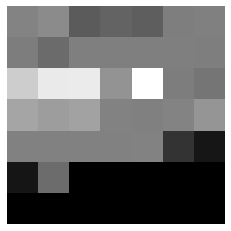

In [36]:
plotImage(getImgPixels(list(ratios_with_dif.loc[0]), getMeanVars(ratios_with_dif), getStdVars(ratios_with_dif)))

Se guarda en una variable la ruta del dataset dsa2. 

**SIN EMBARGO, COMO LOS DATASETS YA SE ENTREGAN FORMADOS NO HACE FALTA LLAMAR AL MÉTODO GENERATEIMAGES() DE NUEVO**. Así, se establece una ruta absoluta hacia el dataset dsa2

**CAMBIAR ESTA RUTA SI SE EJECUTA EN LOCAL**

In [37]:
#path_dsa2 = generateImages(ratios_with_dif, "./", "dsa2")
path_dsa2 = '../input/dataset/dsa2/dsa2'

### GENERACIÓN DE IMÁGENES: variables iniciales + diferencias con la media + variables iniciales al cuadrado

Generamos otro dataframe nuevo como antes

In [38]:
ratios_with_sq = ratios_with_dif.copy()
eti_column = ratios_with_sq['etiqueta']
ratios_with_sq.drop('etiqueta', axis=1, inplace=True)

sq_columns = ['sq-r_end1','sq-r_end2','sq-roa','sq-roa_expl','sq-r_rent_negc','sq-roe', 'sq-ros','sq-r_sub1','sq-r_sub2',
               'sq-r_sub3','sq-r_csd','sq-r_solv','sq-icr_1','sq-icr_2','sq-log_activos','sq-log_pasivos','sq-log_drt',
               'sq-log_cifra_negocios','sq-edad']

for ratio_column,sq_column in zip(list(ratios.describe().columns),sq_columns):
    ratios_with_sq[sq_column] = ratios_with_sq[ratio_column] ** 2 

ratios_with_sq['etiqueta'] = eti_column
ratios_with_sq.head()

,r_end1,r_end2,roa,roa_expl,r_rent_negc,roe,ros,r_sub1,r_sub2,r_sub3,...,sq-r_csd,sq-r_solv,sq-icr_1,sq-icr_2,sq-log_activos,sq-log_pasivos,sq-log_drt,sq-log_cifra_negocios,sq-edad,etiqueta
0,0.783513,0.670432,-0.037340,-0.055731,0.020793,-0.138459,-0.074179,0.007613,0.003832,-0.127848,...,0.000962,1.628951,201.200196,62.392453,42.320597,40.953272,40.091479,38.530796,1110.928969,1
1,0.640824,0.436990,0.017587,0.024439,0.041760,0.036581,0.022488,0.000000,0.000000,0.000000,...,0.009132,2.435132,66043.065495,372367.206466,34.493816,32.261063,30.399956,33.251238,790.611139,1
2,0.341556,0.127092,-0.059229,-0.047842,-0.037161,-0.099011,-0.045334,0.054358,0.071017,-1.089339,...,0.085495,8.571890,108.741043,42.805982,36.476969,31.059202,26.457998,37.892892,811.391323,1
3,0.954114,0.713115,-0.188774,-0.234995,-0.133101,-3.224548,-0.135233,0.001189,0.001660,-0.011217,...,0.034837,1.098499,484.333709,240.780373,40.522992,40.263686,38.675048,42.388247,796.167394,1
4,0.510644,0.440711,0.005061,0.010711,0.050858,-0.024162,0.012153,0.031948,0.013304,-1.125185,...,0.013317,3.834982,0.070463,7.115332,39.140376,35.573415,34.814491,34.524674,839.099436,1


Mostramos la imagen para la misma empresa zombi de nuevo

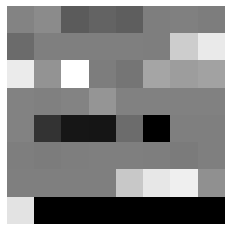

In [39]:
plotImage(getImgPixels(list(ratios_with_sq.loc[0]), getMeanVars(ratios_with_sq), getStdVars(ratios_with_sq)))

Se guarda en una variable la ruta del dataset dsa3.

**SIN EMBARGO, COMO LOS DATASETS YA SE ENTREGAN FORMADOS NO HACE FALTA LLAMAR AL MÉTODO GENERATEIMAGES() DE NUEVO**. Así, se establece una ruta absoluta hacia el dataset dsa3

**CAMBIAR ESTA RUTA SI SE EJECUTA EN LOCAL**

In [40]:
#path_dsa3 = generateImages(ratios_with_sq, "./", "dsa3")
path_dsa3 = '../input/dataset/dsa3/dsa3'

### GENERACIÓN DE IMÁGENES CON EL MÉTODO CORRELACIONADO

A continuación se procede a explicar cada una de las siguientes funciones que nos permitirán la generación de imágenes correlacionadas:
- ***getCorrDict(sme_vars):*** función que devuelve un diccionario que contiene las correlaciones de una variable de la empresa con las demás variables de la misma empresa
- ***getPixelCorrDict(sme_vars):*** función que devuelve un array bidimensional (imagen) con la distribución inicial de las variables de la empresa. Además, también retorna un diccionario que indica la variable que contiene cada pixel de la imagen.
- ***d(pixel_i_cords, pixel_j_cords):*** función que calcula la distancia entre dos pixeles igual como en el estudio de Hosaka
- ***swapPixelsInfo(px1, px2, sme_vars, img_arr, pixel_dict):*** función que devuelve la nueva imagen tras intercambiar los pixeles px1 y px2.
- ***e(pixel_combinations, corr_dict, pixel_dict):*** función que calcula la energía teniendo en cuenta todas las posibles combinaciones de los pixeles
- ***getFinalPixels(img_arr, pixel_dict, mean_vars, std_vars):*** función que devuelve los pixeles de la imagen final normalizados como en el estudio de Hosaka
- ***getCorrImgPixels(sme_vars, mean_vars, std_vars):*** función que retorna los pixeles de una imagen con el método correlacionado de Hosaka 


In [41]:
def getCorrDict(sme_vars):
    corr_dict = {}
    for i in range(0,len(sme_vars)):
        # previous ratios
        for j in range(0,i):
            key = (i,j)
            if sme_vars[j] != 0:
                corr_dict[key] = sme_vars[i]/sme_vars[j]
            else:
                corr_dict[key] = 0
        # next ratios
        for j in range(i,len(sme_vars)):
            key = (i,j)
            if sme_vars[j] != 0:
                corr_dict[key] = sme_vars[i]/sme_vars[j]
            else:
                corr_dict[key] = 0
    return corr_dict

def getPixelCorrDict(sme_vars):
    dim, index = math.ceil(math.sqrt(len(sme_vars))), 0
    img_arr = np.zeros((dim,dim),dtype=float)
    pixel_dict = {}
    for i in range(0,img_arr.shape[0]):
        for j in range(0,img_arr.shape[1]):
            if index < len(sme_vars):
                pixel_dict[(i,j)] = index 
                img_arr[i][j] = sme_vars[index]
                index+=1
            else: break
    return (pixel_dict, img_arr)

def d(pixel_i_cords, pixel_j_cords):
    res = pow(pixel_i_cords[1]-pixel_j_cords[1],2) + pow(pixel_i_cords[0]-pixel_j_cords[0],2)
    return res

def swapPixelsInfo(px1, px2, sme_vars, img_arr, pixel_dict):
    # Intercambio de pixeles y modificación de la imagen:
    img_arr[px1[0]][px1[1]] = sme_vars[pixel_dict[px2]]
    img_arr[px2[0]][px2[1]] = sme_vars[pixel_dict[px1]]
    pixel_dict[px1], pixel_dict[px2] = pixel_dict[px2], pixel_dict[px1]
    return (img_arr,pixel_dict)
    
    
def e(pixel_combinations, corr_dict, pixel_dict):
    energy = None
    for px1_cords,px2_cords in pixel_combinations:
        if energy is None:
            energy = abs(corr_dict[(pixel_dict[px1_cords],pixel_dict[px2_cords])]) * d(px1_cords, px2_cords)
        else:
            energy += abs(corr_dict[(pixel_dict[px1_cords],pixel_dict[px2_cords])]) * d(px1_cords, px2_cords)
    return energy

def getFinalPixels(img_arr, pixel_dict, mean_vars, std_vars):
    for i in range(img_arr.shape[0]):
        for j in range(img_arr.shape[1]):
            key = (i,j)
            if key not in pixel_dict.keys(): return img_arr
            
            pixel_value = ((img_arr[i][j] - mean_vars[pixel_dict[key]])/std_vars[pixel_dict[key]])*100 +128
            
            if pixel_value > 255: pixel_value = 255
            if pixel_value < 0: pixel_value = 0
            
            img_arr[i][j] = pixel_value
    return img_arr
                
def getCorrImgPixels(sme_vars, mean_vars, std_vars):
    corr_dict = getCorrDict(sme_vars)
    pixel_dict,img_arr = getPixelCorrDict(sme_vars)
    
    # Se eliminan las correlaciones donde i = j
    final_keys = [(i,j) for i,j in corr_dict.keys() if i!=j]
    
    # Se generan todas las posibles combinaciones de los pixeles
    pixel_combinations = [[(int(i/img_arr.shape[0]),i%img_arr.shape[0]),(int(j/img_arr.shape[0]),j%img_arr.shape[0])] for i,j in final_keys]
    
    # Límite de parada de la función
    counter,threshold= 0,len(sme_vars)
    
    def mainAlgorithm(energy_to_compare=None):
        nonlocal pixel_dict, img_arr
        
        if energy_to_compare is None:
            # Es la primera vez que vamos a calcular la energía:
            return e(pixel_combinations, corr_dict, pixel_dict)
        else:
            # No es la primera vez. Por lo tanto calculamos la nueva energía y la comparamos con la anterior
            # Escogemos dos pixeles alzar y los intercambiamos
            px1, px2 = random.choice(list(pixel_dict.keys())), random.choice(list(pixel_dict.keys()))
            img_arr, pixel_dict = swapPixelsInfo(px1, px2, sme_vars, img_arr, pixel_dict)
            
            energy = e(pixel_combinations, corr_dict, pixel_dict)
            
            if energy < energy_to_compare:
                return energy
            else:
                # Nose pudo reducir la energia, por lo tanto se intercambian los pixeles de nuevo como estaban antes
                img_arr,pixel_dict = swapPixelsInfo(px1,px2,sme_vars, img_arr, pixel_dict)
                return energy_to_compare
    
    # Energia inicial
    e0 = mainAlgorithm()
    prev = e0
    
    while counter < threshold:
        e1 = mainAlgorithm(prev)
        if e1 == prev:
            counter+=1
        else:
            prev = e1
            counter = 0
        
    # Se obtienen los pixeles finales de la imagen normalizados por la ecuación 10 del informe
    img_arr = getFinalPixels(img_arr, pixel_dict, mean_vars, std_vars)
    
    return img_arr  

Mostramos como se verían las tres tipos de imagenes para la primera empresa zombi con el método correlacionado

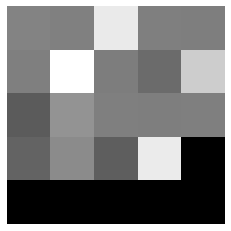

In [42]:
plotImage(getCorrImgPixels(list(ratios.loc[0])[:-1], getMeanVars(ratios), getStdVars(ratios)))

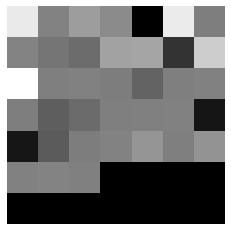

In [43]:
plotImage(getCorrImgPixels(list(ratios_with_dif.loc[0])[:-1], getMeanVars(ratios_with_dif), getStdVars(ratios_with_dif)))

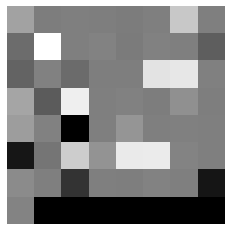

In [44]:
plotImage(getCorrImgPixels(list(ratios_with_sq.loc[0])[:-1], getMeanVars(ratios_with_sq), getStdVars(ratios_with_sq)))

Generamos los tres datasets nuevos y guardamos sus rutas, igual que hicimos antes.

**SIN EMBARGO, COMO LOS DATASETS YA SE ENTREGAN FORMADOS NO HACE FALTA LLAMAR AL MÉTODO GENERATEIMAGES() DE NUEVO**. Así, se establece una ruta absoluta hacia el dataset dsc1, dsc2 y dsc3

**CAMBIAR ESTA RUTA SI SE EJECUTA EN LOCAL**

In [45]:
#path_dsc1 = generateImages(ratios, "./", "dsc1", corr=True)
#path_dsc2 = generateImages(ratios_with_dif, "./", "dsc2", corr=True)
#path_dsc3 = generateImages(ratios_with_sq, "./", "dsc3", corr=True)
path_dsc1 = '../input/dataset/dsc1/dsc1'
path_dsc2 = '../input/dataset/dsc2/dsc2'
path_dsc3 = '../input/dataset/dsc3/dsc3'

## MODELADO

### GENERACIÓN DEL PLAN DE PRUEBA

Se decarga la librería que permitirá dividir cada dataset en subconjunto de entrenamiento, validación y test

In [46]:
!pip install split-folders
import splitfolders

Se realiza la división de los seis datasets de imágenes en conjuntos de entrenamiento, validación y test

**SI SE EJECUTA EN LOCAL, SE RECOMIENDA LA CREACIÓN DE LOS SIGUIENTES DIRECTORIOS DONDE SE GUARDARÁN LOS DATASETS DIVIDIDOS**

In [47]:
mkdir './dsa1'| mkdir './dsa2'| mkdir './dsa3'| mkdir './dsc1'| mkdir './dsc2'| mkdir './dsc3'

**CAMBIAR LAS SIGUIENTES RUTAS SI SE EJECUTA EN LOCAL. EN ESTAS RUTAS ES DONDE SE GENERARÁN LOS DATASETS DIVIDIDOS**

In [48]:
output_path_dsa1 = './dsa1'
output_path_dsa2 = './dsa2'
output_path_dsa3 = './dsa3'
output_path_dsc1 = './dsc1'
output_path_dsc2 = './dsc2'
output_path_dsc3 = './dsc3'

In [49]:
splitfolders.ratio(path_dsa1, output=output_path_dsa1 ,seed=1337, ratio=(0.8, 0.1, 0.1))
splitfolders.ratio(path_dsa2, output=output_path_dsa2 ,seed=1337, ratio=(0.8, 0.1, 0.1))
splitfolders.ratio(path_dsa3, output=output_path_dsa3 ,seed=1337, ratio=(0.8, 0.1, 0.1))
splitfolders.ratio(path_dsc1, output=output_path_dsc1 ,seed=1337, ratio=(0.8, 0.1, 0.1))
splitfolders.ratio(path_dsc2, output=output_path_dsc2 ,seed=1337, ratio=(0.8, 0.1, 0.1))
splitfolders.ratio(path_dsc3, output=output_path_dsc3 ,seed=1337, ratio=(0.8, 0.1, 0.1))

Copying files: 8001 files [00:37, 212.01 files/s]
Copying files: 8001 files [00:40, 199.36 files/s]
Copying files: 8001 files [00:44, 180.44 files/s]
Copying files: 8001 files [00:45, 175.81 files/s]
Copying files: 8001 files [00:44, 181.61 files/s]
Copying files: 8001 files [00:44, 178.72 files/s]


También generamos los distintos conjuntos de entrenamientos, validación y test para la regresión logística

In [50]:
X1 = ratios.loc[:, ratios.columns != 'etiqueta']
y1 = ratios.loc[:, ratios.columns == 'etiqueta']
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size=0.2,random_state=1337)

In [51]:
X2 = ratios_with_dif.loc[:, ratios_with_dif.columns != 'etiqueta']
y2 = ratios_with_dif.loc[:, ratios_with_dif.columns == 'etiqueta']
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2,test_size=0.2,random_state=1337)

In [52]:
X3 = ratios_with_sq.loc[:, ratios_with_sq.columns != 'etiqueta']
y3 = ratios_with_sq.loc[:, ratios_with_sq.columns == 'etiqueta']
X3_train,X3_test,y3_train,y3_test = train_test_split(X3,y3,test_size=0.2,random_state=1337)

Se visualiza el desbalance de las clases

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Porcentaje de pymes que son zombis (1) o no zombis (0)')

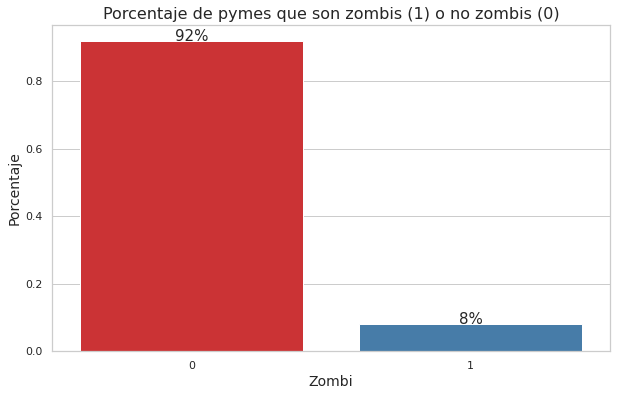

In [53]:
#Ploting barplot for target 
plt.figure(figsize=(10,6))
g = sns.barplot(ratios['etiqueta'], ratios['etiqueta'], palette='Set1', estimator=lambda x: len(x) / len(ratios['etiqueta']) )

#Anotating the graph
for p in g.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        g.text(x+width/2, 
               y+height, 
               '{:.0%}'.format(height), 
               horizontalalignment='center',fontsize=15)

#Setting the labels
plt.xlabel('Zombi', fontsize=14)
plt.ylabel('Porcentaje', fontsize=14)
plt.title('Porcentaje de pymes que son zombis (1) o no zombis (0)', fontsize=16)

Se calculan los pesos por cada una de las clases en el conjunto de entrenamiento

In [54]:
CLASS_WEIGHTS = {}

COUNT_Z = y1_train[y1_train['etiqueta'] == 1].shape[0]
COUNT_NZ = y1_train[y1_train['etiqueta'] == 0].shape[0]
COUNT = COUNT_Z + COUNT_NZ

CLASS_WEIGHTS[0] = (1/COUNT_NZ)*(COUNT)/2.0
CLASS_WEIGHTS[1] = (1/COUNT_Z)*(COUNT)/2.0

CLASS_WEIGHTS

{0: 0.5438477226376615, 1: 6.2015503875969}

### CONSTRUCCIÓN DE LOS MODELOS

Definimos los parametros a usar en los distintos modelos

In [55]:
EPOCHS = 10
BATCH_SIZE = 32
METRICS = [
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    AUC(name='auc')]

2022-01-28 01:49:02.893397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 01:49:02.992355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 01:49:02.993095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 01:49:02.994892: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Se crean los metodos necesarios para el entrenamiento de la CNN

In [56]:
def getTrainValTestPath(ds_path):
    return [ds_path+'/train', ds_path+'/val', ds_path+'/test']

def plotImages(images_arr):
    fig, axes = plt.subplots(1, BATCH_SIZE, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img[:,:,0],cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def plotAuc(history, name):
    plt.plot(history.history['final_classifier_auc'], 
         label='Training AUC (area = {:.3f})'.format(history.history['final_classifier_auc'][-1]))
    plt.plot(history.history['val_final_classifier_auc'], 
             label='Validation AUC ( area = {:.3f})'.format(history.history['val_final_classifier_auc'][-1]))
    plt.title(name)
    plt.ylabel('Final classifier AUC')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend(loc='best')

    plt.show()

def plotLoss(history, name):
    plt.plot(history.history['final_classifier_loss'], label='Training loss (loss = {:.3f})'.format(history.history['final_classifier_loss'][-1]))
    plt.plot(history.history['val_final_classifier_loss'], label='Validation loss (loss = {:.3f})'.format(history.history['val_final_classifier_loss'][-1]))
    plt.title('Model ' + name +  ' loss')
    plt.ylabel('Final classifier loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend(loc='best')

    plt.show() 

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

def GoogLeNet():
    # input layer 
    input_layer = Input(shape = (224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)    
    #X1 = Dense(5, activation = 'softmax')(X1) --> ORIGINAL
    X1 = Dense(1, activation = 'sigmoid', name='first_extra_network')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    #X2 = Dense(1000, activation = 'softmax')(X2) --> ORIGINAL
    X2 = Dense(1, activation = 'sigmoid', name='second_extra_network')(X2)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer
    #X = Dense(1000, activation = 'softmax')(X) --> ORIGINAL
    X = Dense(1, activation = 'sigmoid', name='final_classifier')(X)

    # model
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')
    
    model.compile(loss=BinaryCrossentropy(),
                  optimizer=Adam(),
                  metrics=METRICS)

    return model

def trainCnnModel(model, train_batches, valid_batches, checkpoint_filepath):
    
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                monitor='val_final_classifier_auc',
                                                mode='max',
                                                verbose=1,
                                                save_best_only=True)
    
    h = model.fit(train_batches,
            validation_data=valid_batches,
            steps_per_epoch=train_batches.n//train_batches.batch_size,
            validation_steps=valid_batches.n//valid_batches.batch_size,    
            class_weight=CLASS_WEIGHTS,
            callbacks=[model_checkpoint_callback],
            epochs=EPOCHS
    )
    
    return h

#### ENTRENAMIENTO CNN DSA1

In [57]:
train_path_dsa1, valid_path_dsa1, test_path_dsa1 = getTrainValTestPath(output_path_dsa1)
train_batches_dsa1 = ImageDataGenerator().flow_from_directory(directory=train_path_dsa1, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE)
valid_batches_dsa1 = ImageDataGenerator().flow_from_directory(directory=valid_path_dsa1, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE)
test_batches_dsa1 = ImageDataGenerator().flow_from_directory(directory=test_path_dsa1, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE, shuffle=False)

Found 6400 images belonging to 2 classes.
Found 799 images belonging to 2 classes.
Found 802 images belonging to 2 classes.


{'no_zombie': 0, 'zombie': 1}


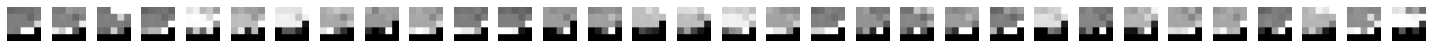

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [58]:
imgs, labels = next(train_batches_dsa1)
print(train_batches_dsa1.class_indices)
plotImages(imgs)
print(labels)

In [59]:
model_dsa1 = GoogLeNet()
model_dsa1.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 109, 109, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 54, 54, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 54, 54, 64)   4160        max_pooling2d[0][0]              
__________________________________________________________________________________________

**CAMBIAR RUTA SI SE EJECUTA EN LOCAL**

In [60]:
history_dsa1 = trainCnnModel(model_dsa1, train_batches_dsa1, valid_batches_dsa1, './model_dsa1.h5')

2022-01-28 01:49:19.097882: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-01-28 01:49:25.762916: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


200/200 [==============================] - 33s 99ms/step - loss: 2.1339 - final_classifier_loss: 0.7062 - first_extra_network_loss: 0.7433 - second_extra_network_loss: 0.6845 - final_classifier_tp: 321.0000 - final_classifier_fp: 3113.0000 - final_classifier_tn: 2770.0000 - final_classifier_fn: 196.0000 - final_classifier_auc: 0.5833 - first_extra_network_tp: 288.0000 - first_extra_network_fp: 2172.0000 - first_extra_network_tn: 3711.0000 - first_extra_network_fn: 229.0000 - first_extra_network_auc: 0.6264 - second_extra_network_tp: 294.0000 - second_extra_network_fp: 2338.0000 - second_extra_network_tn: 3545.0000 - second_extra_network_fn: 223.0000 - second_extra_network_auc: 0.6209 - val_loss: 2.0597 - val_final_classifier_loss: 0.6609 - val_first_extra_network_loss: 0.7088 - val_second_extra_network_loss: 0.6900 - val_final_classifier_tp: 50.0000 - val_final_classifier_fp: 286.0000 - val_final_classifier_tn: 421.0000 - val_final_classifier_fn: 11.0000 - val_final_classifier_auc: 0.8

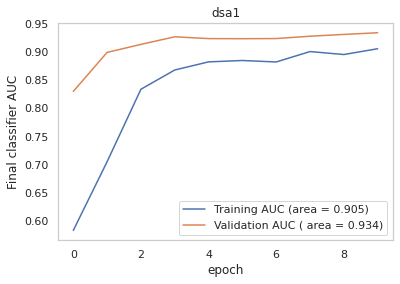

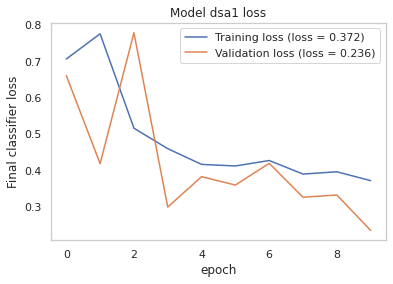

In [61]:
plotAuc(history_dsa1, "dsa1")
plotLoss(history_dsa1, "dsa1")

#### ENTRENAMIENTO CNN DSA2

In [62]:
train_path_dsa2, valid_path_dsa2, test_path_dsa2 = getTrainValTestPath(output_path_dsa2)
train_batches_dsa2 = ImageDataGenerator().flow_from_directory(directory=train_path_dsa2, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE)
valid_batches_dsa2 = ImageDataGenerator().flow_from_directory(directory=valid_path_dsa2, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE)
test_batches_dsa2 = ImageDataGenerator().flow_from_directory(directory=test_path_dsa2, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE, shuffle=False)

Found 6400 images belonging to 2 classes.
Found 799 images belonging to 2 classes.
Found 802 images belonging to 2 classes.


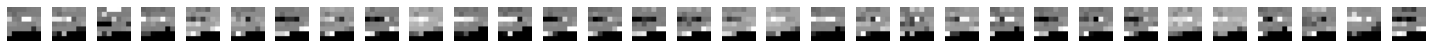

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [63]:
imgs, labels = next(train_batches_dsa2)
plotImages(imgs)
print(labels)

**CAMBIAR RUTA SI SE EJECUTA EN LOCAL**

In [64]:
model_dsa2 = GoogLeNet()
history_dsa2 = trainCnnModel(model_dsa2, train_batches_dsa2, valid_batches_dsa2, './model_dsa2.h5')

Epoch 1/10
200/200 [==============================] - 25s 99ms/step - loss: 2.2563 - final_classifier_loss: 0.7175 - first_extra_network_loss: 0.8088 - second_extra_network_loss: 0.7299 - final_classifier_tp: 245.0000 - final_classifier_fp: 2830.0000 - final_classifier_tn: 3053.0000 - final_classifier_fn: 272.0000 - final_classifier_auc: 0.5006 - first_extra_network_tp: 325.0000 - first_extra_network_fp: 2949.0000 - first_extra_network_tn: 2934.0000 - first_extra_network_fn: 192.0000 - first_extra_network_auc: 0.5815 - second_extra_network_tp: 277.0000 - second_extra_network_fp: 2817.0000 - second_extra_network_tn: 3066.0000 - second_extra_network_fn: 240.0000 - second_extra_network_auc: 0.5412 - val_loss: 2.0262 - val_final_classifier_loss: 0.6607 - val_first_extra_network_loss: 0.6932 - val_second_extra_network_loss: 0.6723 - val_final_classifier_tp: 0.0000e+00 - val_final_classifier_fp: 0.0000e+00 - val_final_classifier_tn: 707.0000 - val_final_classifier_fn: 61.0000 - val_final_cla

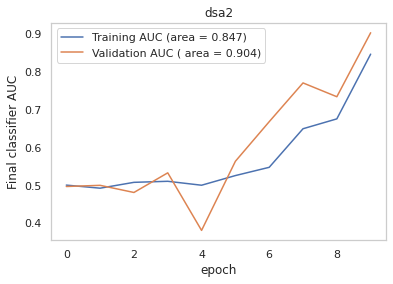

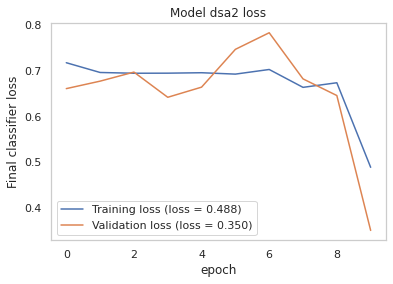

In [65]:
plotAuc(history_dsa2, "dsa2")
plotLoss(history_dsa2, "dsa2")

#### ENTRENAMIENTO CNN DSA3

In [66]:
train_path_dsa3, valid_path_dsa3, test_path_dsa3 = getTrainValTestPath(output_path_dsa3)
train_batches_dsa3 = ImageDataGenerator().flow_from_directory(directory=train_path_dsa3, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE)
valid_batches_dsa3 = ImageDataGenerator().flow_from_directory(directory=valid_path_dsa3, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE)
test_batches_dsa3 = ImageDataGenerator().flow_from_directory(directory=test_path_dsa3, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE, shuffle=False)

Found 6400 images belonging to 2 classes.
Found 799 images belonging to 2 classes.
Found 802 images belonging to 2 classes.


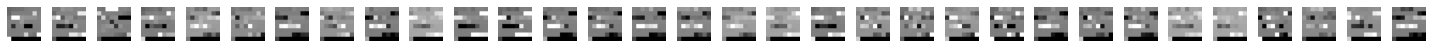

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [67]:
imgs, labels = next(train_batches_dsa3)
plotImages(imgs)
print(labels)

**CAMBIAR RUTA SI SE EJECUTA EN LOCAL**

In [68]:
model_dsa3 = GoogLeNet()
history_dsa3 = trainCnnModel(model_dsa3, train_batches_dsa3, valid_batches_dsa3, './model_dsa3.h5')

Epoch 1/10
200/200 [==============================] - 25s 99ms/step - loss: 2.2792 - final_classifier_loss: 0.7207 - first_extra_network_loss: 0.8135 - second_extra_network_loss: 0.7450 - final_classifier_tp: 285.0000 - final_classifier_fp: 3439.0000 - final_classifier_tn: 2444.0000 - final_classifier_fn: 232.0000 - final_classifier_auc: 0.4787 - first_extra_network_tp: 285.0000 - first_extra_network_fp: 3159.0000 - first_extra_network_tn: 2724.0000 - first_extra_network_fn: 232.0000 - first_extra_network_auc: 0.5104 - second_extra_network_tp: 283.0000 - second_extra_network_fp: 3283.0000 - second_extra_network_tn: 2600.0000 - second_extra_network_fn: 234.0000 - second_extra_network_auc: 0.4919 - val_loss: 2.0764 - val_final_classifier_loss: 0.7041 - val_first_extra_network_loss: 0.6701 - val_second_extra_network_loss: 0.7022 - val_final_classifier_tp: 61.0000 - val_final_classifier_fp: 707.0000 - val_final_classifier_tn: 0.0000e+00 - val_final_classifier_fn: 0.0000e+00 - val_final_cla

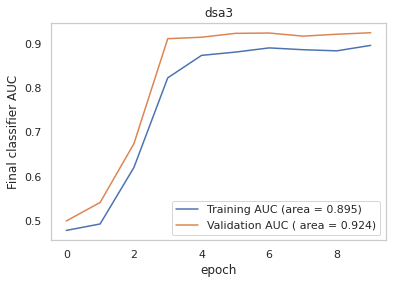

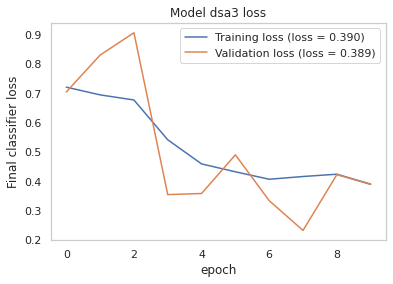

In [69]:
plotAuc(history_dsa3, "dsa3")
plotLoss(history_dsa3, "dsa3")

#### ENTRENAMIENTO CNN DSC1

In [70]:
train_path_dsc1, valid_path_dsc1, test_path_dsc1 = getTrainValTestPath(output_path_dsc1)
train_batches_dsc1 = ImageDataGenerator().flow_from_directory(directory=train_path_dsc1, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE)
valid_batches_dsc1 = ImageDataGenerator().flow_from_directory(directory=valid_path_dsc1, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE)
test_batches_dsc1 = ImageDataGenerator().flow_from_directory(directory=test_path_dsc1, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE, shuffle=False)

Found 6400 images belonging to 2 classes.
Found 799 images belonging to 2 classes.
Found 802 images belonging to 2 classes.


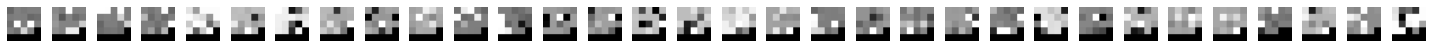

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [71]:
imgs, labels = next(train_batches_dsc1)
plotImages(imgs)
print(labels)

**CAMBIAR RUTA SI SE EJECUTA EN LOCAL**

In [72]:
model_dsc1 = GoogLeNet()
history_dsc1 = trainCnnModel(model_dsc1, train_batches_dsc1, valid_batches_dsc1, './model_dsc1.h5')

Epoch 1/10
200/200 [==============================] - 25s 96ms/step - loss: 2.3126 - final_classifier_loss: 0.7389 - first_extra_network_loss: 0.8503 - second_extra_network_loss: 0.7233 - final_classifier_tp: 264.0000 - final_classifier_fp: 3281.0000 - final_classifier_tn: 2602.0000 - final_classifier_fn: 253.0000 - final_classifier_auc: 0.4787 - first_extra_network_tp: 285.0000 - first_extra_network_fp: 3537.0000 - first_extra_network_tn: 2346.0000 - first_extra_network_fn: 232.0000 - first_extra_network_auc: 0.4781 - second_extra_network_tp: 284.0000 - second_extra_network_fp: 3509.0000 - second_extra_network_tn: 2374.0000 - second_extra_network_fn: 233.0000 - second_extra_network_auc: 0.4754 - val_loss: 2.1203 - val_final_classifier_loss: 0.7012 - val_first_extra_network_loss: 0.7113 - val_second_extra_network_loss: 0.7078 - val_final_classifier_tp: 61.0000 - val_final_classifier_fp: 707.0000 - val_final_classifier_tn: 0.0000e+00 - val_final_classifier_fn: 0.0000e+00 - val_final_cla

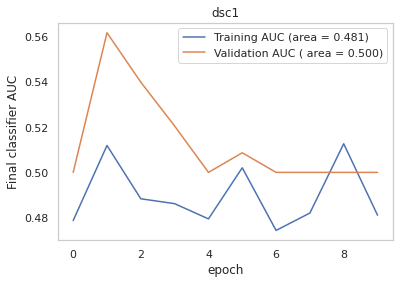

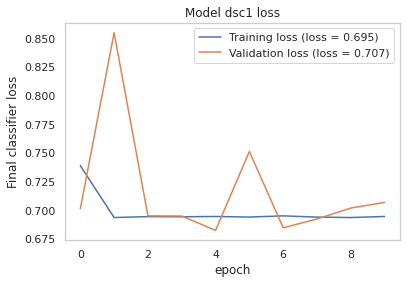

In [73]:
plotAuc(history_dsc1, "dsc1")
plotLoss(history_dsc1, "dsc1")

#### ENTRENAMIENTO CNN DSC2

In [74]:
train_path_dsc2, valid_path_dsc2, test_path_dsc2 = getTrainValTestPath(output_path_dsc2)
train_batches_dsc2 = ImageDataGenerator().flow_from_directory(directory=train_path_dsc2, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE)
valid_batches_dsc2 = ImageDataGenerator().flow_from_directory(directory=valid_path_dsc2, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE)
test_batches_dsc2 = ImageDataGenerator().flow_from_directory(directory=test_path_dsc2, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE, shuffle=False)

Found 6400 images belonging to 2 classes.
Found 799 images belonging to 2 classes.
Found 802 images belonging to 2 classes.


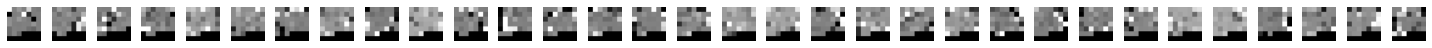

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [75]:
imgs, labels = next(train_batches_dsc2)
plotImages(imgs)
print(labels)

**CAMBIAR RUTA SI SE EJECUTA EN LOCAL**

In [76]:
model_dsc2 = GoogLeNet()
history_dsc2 = trainCnnModel(model_dsc2, train_batches_dsc2, valid_batches_dsc2, './model_dsc2.h5')

Epoch 1/10
200/200 [==============================] - 25s 100ms/step - loss: 3.3452 - final_classifier_loss: 1.1590 - first_extra_network_loss: 1.2936 - second_extra_network_loss: 0.8926 - final_classifier_tp: 407.0000 - final_classifier_fp: 4665.0000 - final_classifier_tn: 1218.0000 - final_classifier_fn: 110.0000 - final_classifier_auc: 0.4983 - first_extra_network_tp: 270.0000 - first_extra_network_fp: 2941.0000 - first_extra_network_tn: 2942.0000 - first_extra_network_fn: 247.0000 - first_extra_network_auc: 0.5213 - second_extra_network_tp: 294.0000 - second_extra_network_fp: 3329.0000 - second_extra_network_tn: 2554.0000 - second_extra_network_fn: 223.0000 - second_extra_network_auc: 0.5019 - val_loss: 2.0700 - val_final_classifier_loss: 0.6876 - val_first_extra_network_loss: 0.7021 - val_second_extra_network_loss: 0.6803 - val_final_classifier_tp: 0.0000e+00 - val_final_classifier_fp: 0.0000e+00 - val_final_classifier_tn: 707.0000 - val_final_classifier_fn: 61.0000 - val_final_cl

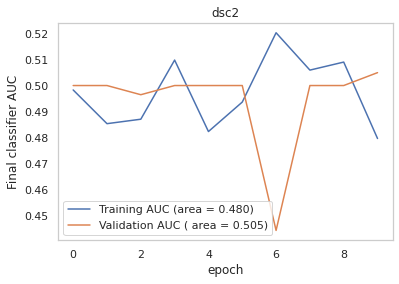

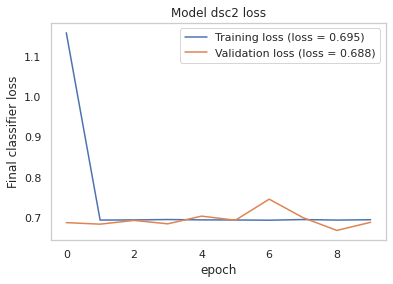

In [77]:
plotAuc(history_dsc2, "dsc2")
plotLoss(history_dsc2, "dsc2")

#### ENTRENAMIENTO CNN DSC3

In [78]:
train_path_dsc3, valid_path_dsc3, test_path_dsc3 = getTrainValTestPath(output_path_dsc3)
train_batches_dsc3 = ImageDataGenerator().flow_from_directory(directory=train_path_dsc3, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE)
valid_batches_dsc3 = ImageDataGenerator().flow_from_directory(directory=valid_path_dsc3, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE)
test_batches_dsc3 = ImageDataGenerator().flow_from_directory(directory=test_path_dsc3, target_size=(224,224), seed=1337, class_mode='binary', batch_size=BATCH_SIZE, shuffle=False)

Found 6400 images belonging to 2 classes.
Found 799 images belonging to 2 classes.
Found 802 images belonging to 2 classes.


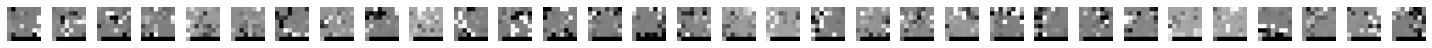

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [79]:
imgs, labels = next(train_batches_dsc3)
plotImages(imgs)
print(labels)

**CAMBIAR RUTA SI SE EJECUTA EN LOCAL**

In [80]:
model_dsc3 = GoogLeNet()
history_dsc3 = trainCnnModel(model_dsc3, train_batches_dsc3, valid_batches_dsc3, './model_dsc3.h5')

Epoch 1/10
200/200 [==============================] - 26s 101ms/step - loss: 2.7496 - final_classifier_loss: 0.8730 - first_extra_network_loss: 1.0269 - second_extra_network_loss: 0.8497 - final_classifier_tp: 326.0000 - final_classifier_fp: 3559.0000 - final_classifier_tn: 2324.0000 - final_classifier_fn: 191.0000 - final_classifier_auc: 0.5234 - first_extra_network_tp: 269.0000 - first_extra_network_fp: 3034.0000 - first_extra_network_tn: 2849.0000 - first_extra_network_fn: 248.0000 - first_extra_network_auc: 0.4999 - second_extra_network_tp: 269.0000 - second_extra_network_fp: 3006.0000 - second_extra_network_tn: 2877.0000 - second_extra_network_fn: 248.0000 - second_extra_network_auc: 0.4877 - val_loss: 2.4708 - val_final_classifier_loss: 0.7425 - val_first_extra_network_loss: 0.8547 - val_second_extra_network_loss: 0.8736 - val_final_classifier_tp: 61.0000 - val_final_classifier_fp: 707.0000 - val_final_classifier_tn: 0.0000e+00 - val_final_classifier_fn: 0.0000e+00 - val_final_cl

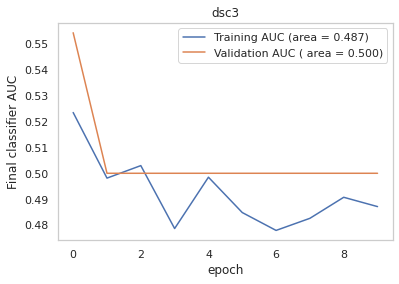

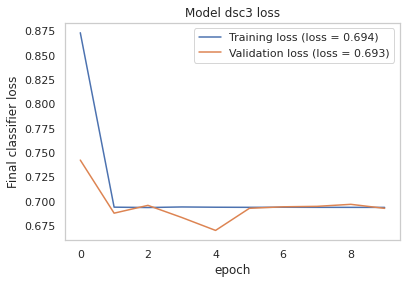

In [81]:
plotAuc(history_dsc3, "dsc3")
plotLoss(history_dsc3, "dsc3")

#### ENTRENAMIENTO REGRESIÓN LOGÍSTICA CON DF: ratios, ratios_with_dif y ratios_with_sq

In [82]:
logreg_1 = LogisticRegression(solver='liblinear', class_weight=CLASS_WEIGHTS, max_iter=1000)
logreg_1.fit(X1_train,np.array(list(y1_train.etiqueta)))

LogisticRegression(class_weight={0: 0.5438477226376615, 1: 6.2015503875969},
                   max_iter=1000, solver='liblinear')

In [83]:
logreg_2 = LogisticRegression(solver='liblinear', class_weight=CLASS_WEIGHTS, max_iter=1000)
logreg_2.fit(X2_train,np.array(list(y2_train.etiqueta)))

LogisticRegression(class_weight={0: 0.5438477226376615, 1: 6.2015503875969},
                   max_iter=1000, solver='liblinear')

In [84]:
logreg_3 = LogisticRegression(solver='liblinear', class_weight=CLASS_WEIGHTS, max_iter=1000)
logreg_3.fit(X3_train,np.array(list(y3_train.etiqueta)))

LogisticRegression(class_weight={0: 0.5438477226376615, 1: 6.2015503875969},
                   max_iter=1000, solver='liblinear')

### EVALUACIÓN DE LOS MODELOS

In [85]:
cm_plot_labels = ['no_zombie','zombie']

In [86]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

def showMetrics(classes, predictions, name):
    
    print(metrics.classification_report(classes, predictions))
    
    fpr, tpr, tr = metrics.roc_curve(classes, predictions)
    auc = metrics.roc_auc_score(classes, predictions)
    plt.plot(fpr,tpr,'b',label="AUC="+str(auc))
    plt.plot([0,1],[0,1],'k--')
    plt.title(name)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

#### EVALUACIÓN MODELO CNN DSA1

**Matriz de confusión**

26/26 [==============================] - 2s 44ms/step
Confusion matrix, without normalization
[[619 117]
 [ 11  55]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


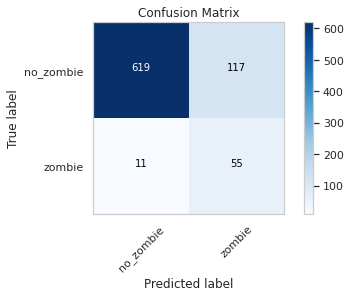

In [87]:
predictions_dsa1 = model_dsa1.predict(x=test_batches_dsa1, verbose=1)[0]
cm_dsa1 = confusion_matrix(y_true=test_batches_dsa1.classes, y_pred=np.round(predictions_dsa1))
plot_confusion_matrix(cm=cm_dsa1, classes=cm_plot_labels, title='Confusion Matrix')

**Resto de métricas**

              precision    recall  f1-score   support

           0       0.98      0.84      0.91       736
           1       0.32      0.83      0.46        66

    accuracy                           0.84       802
   macro avg       0.65      0.84      0.68       802
weighted avg       0.93      0.84      0.87       802



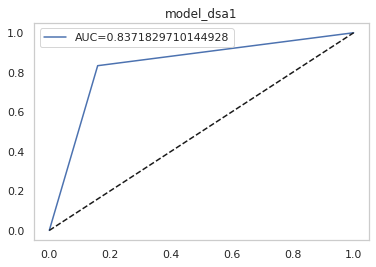

In [88]:
showMetrics(test_batches_dsa1.classes, np.round(predictions_dsa1), 'model_dsa1')

#### EVALUACIÓN MODELO CNN DSA2

**Matriz de confusión**

26/26 [==============================] - 1s 35ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


Confusion matrix, without normalization
[[576 160]
 [  5  61]]


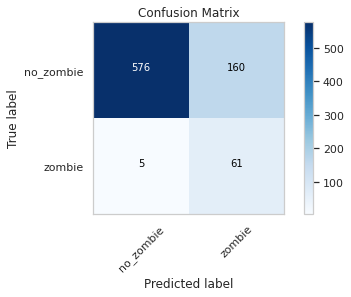

In [89]:
predictions_dsa2 = model_dsa2.predict(x=test_batches_dsa2, verbose=1)[0]
cm_dsa2 = confusion_matrix(y_true=test_batches_dsa2.classes, y_pred=np.round(predictions_dsa2))
plot_confusion_matrix(cm=cm_dsa2, classes=cm_plot_labels, title='Confusion Matrix')

**Resto de métricas**

              precision    recall  f1-score   support

           0       0.99      0.78      0.87       736
           1       0.28      0.92      0.43        66

    accuracy                           0.79       802
   macro avg       0.63      0.85      0.65       802
weighted avg       0.93      0.79      0.84       802



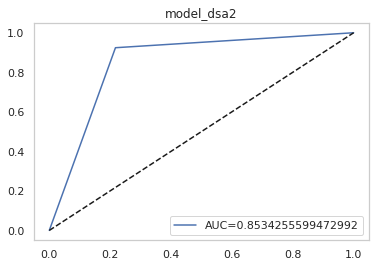

In [90]:
showMetrics(test_batches_dsa2.classes, np.round(predictions_dsa2), 'model_dsa2')

#### EVALUACIÓN MODELO CNN DSA3

**Matriz de confusión**

26/26 [==============================] - 1s 37ms/step
Confusion matrix, without normalization
[[527 209]
 [  5  61]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


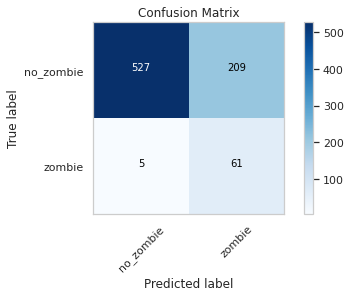

In [91]:
predictions_dsa3 = model_dsa3.predict(x=test_batches_dsa3, verbose=1)[0]
cm_dsa3 = confusion_matrix(y_true=test_batches_dsa3.classes, y_pred=np.round(predictions_dsa3))
plot_confusion_matrix(cm=cm_dsa3, classes=cm_plot_labels, title='Confusion Matrix')

**Resto de métricas**

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       736
           1       0.23      0.92      0.36        66

    accuracy                           0.73       802
   macro avg       0.61      0.82      0.60       802
weighted avg       0.93      0.73      0.79       802



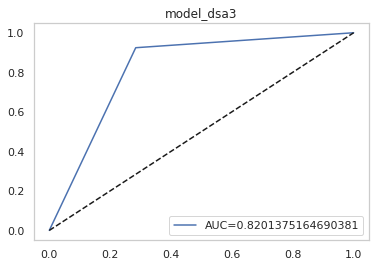

In [92]:
showMetrics(test_batches_dsa3.classes, np.round(predictions_dsa3), 'model_dsa3')

#### EVALUACIÓN MODELO CNN DSC1

**Matriz de confusión**

26/26 [==============================] - 1s 39ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


Confusion matrix, without normalization
[[  0 736]
 [  0  66]]


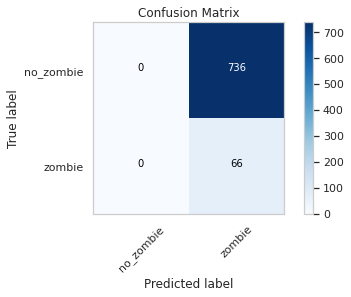

In [93]:
predictions_dsc1 = model_dsc1.predict(x=test_batches_dsc1, verbose=1)[0]
cm_dsc1 = confusion_matrix(y_true=test_batches_dsc1.classes, y_pred=np.round(predictions_dsc1))
plot_confusion_matrix(cm=cm_dsc1, classes=cm_plot_labels, title='Confusion Matrix')

**Resto de métricas**

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       736
           1       0.08      1.00      0.15        66

    accuracy                           0.08       802
   macro avg       0.04      0.50      0.08       802
weighted avg       0.01      0.08      0.01       802



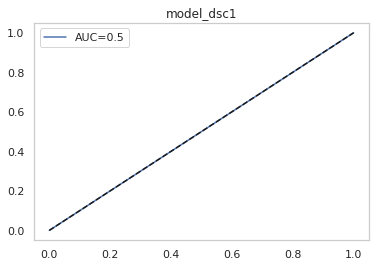

In [94]:
showMetrics(test_batches_dsc1.classes, np.round(predictions_dsc1), 'model_dsc1')

#### EVALUACIÓN MODELO CNN DSC2

**Matriz de confusión**

26/26 [==============================] - 2s 44ms/step
Confusion matrix, without normalization
[[736   0]
 [ 66   0]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


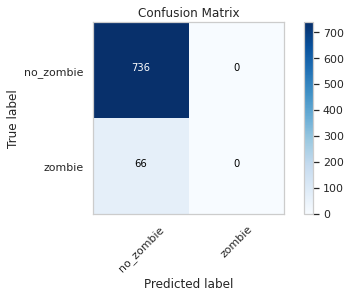

In [95]:
predictions_dsc2 = model_dsc2.predict(x=test_batches_dsc2, verbose=1)[0]
cm_dsc2 = confusion_matrix(y_true=test_batches_dsc2.classes, y_pred=np.round(predictions_dsc2))
plot_confusion_matrix(cm=cm_dsc2, classes=cm_plot_labels, title='Confusion Matrix')

**Resto de métricas**

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96       736
           1       0.00      0.00      0.00        66

    accuracy                           0.92       802
   macro avg       0.46      0.50      0.48       802
weighted avg       0.84      0.92      0.88       802



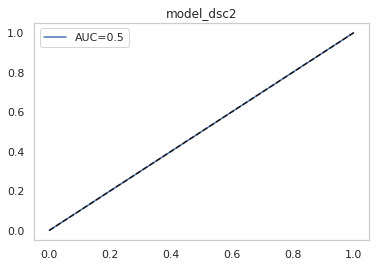

In [96]:
showMetrics(test_batches_dsc2.classes, np.round(predictions_dsc2), 'model_dsc2')

#### EVALUACIÓN MODELO CNN DSC3

**Matriz de confusión**

26/26 [==============================] - 2s 36ms/step
Confusion matrix, without normalization
[[736   0]
 [ 66   0]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


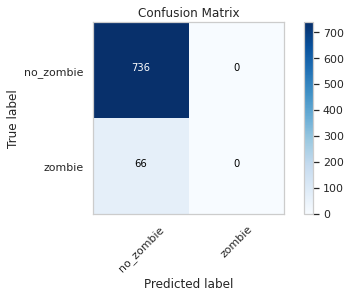

In [97]:
predictions_dsc3 = model_dsc3.predict(x=test_batches_dsc3, verbose=1)[0]
cm_dsc3 = confusion_matrix(y_true=test_batches_dsc3.classes, y_pred=np.round(predictions_dsc3))
plot_confusion_matrix(cm=cm_dsc3, classes=cm_plot_labels, title='Confusion Matrix')

**Resto de métricas**

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96       736
           1       0.00      0.00      0.00        66

    accuracy                           0.92       802
   macro avg       0.46      0.50      0.48       802
weighted avg       0.84      0.92      0.88       802



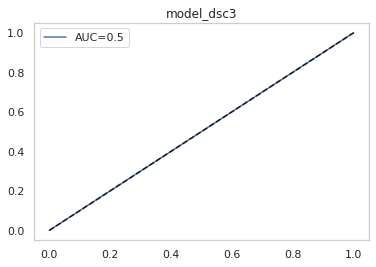

In [98]:
showMetrics(test_batches_dsc3.classes, np.round(predictions_dsc3), 'model_dsc3')

#### EVALUACIÓN REGRESIÓN LINEAL 1

**Matriz de confusión**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


Confusion matrix, without normalization
[[1147  323]
 [  37   94]]


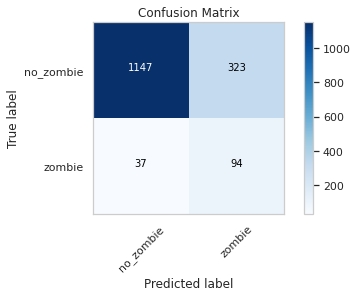

In [99]:
y1_pred = logreg_1.predict(X1_test)
cm1 = confusion_matrix(y1_test, y1_pred)
plot_confusion_matrix(cm=cm1, classes=cm_plot_labels, title='Confusion Matrix')

**Resto de métricas**

              precision    recall  f1-score   support

           0       0.97      0.78      0.86      1470
           1       0.23      0.72      0.34       131

    accuracy                           0.78      1601
   macro avg       0.60      0.75      0.60      1601
weighted avg       0.91      0.78      0.82      1601



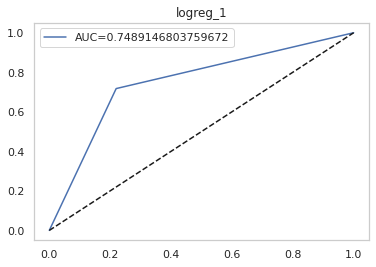

In [100]:
showMetrics(y1_test, y1_pred, 'logreg_1')

#### EVALUACIÓN REGRESIÓN LINEAL 2

**Matriz de confusión**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


Confusion matrix, without normalization
[[1120  350]
 [  39   92]]


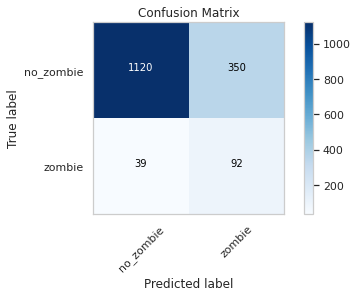

In [101]:
y2_pred = logreg_2.predict(X2_test)
cm2 = confusion_matrix(y2_test, y2_pred)
plot_confusion_matrix(cm=cm2, classes=cm_plot_labels, title='Confusion Matrix')

**Resto de métricas**

              precision    recall  f1-score   support

           0       0.97      0.76      0.85      1470
           1       0.21      0.70      0.32       131

    accuracy                           0.76      1601
   macro avg       0.59      0.73      0.59      1601
weighted avg       0.90      0.76      0.81      1601



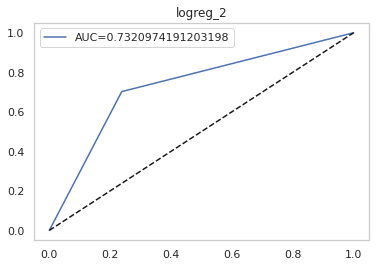

In [102]:
showMetrics(y2_test, y2_pred, 'logreg_2')

#### EVALUACIÓN REGRESIÓN LINEAL 3

**Matriz de confusión**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


Confusion matrix, without normalization
[[994 476]
 [ 87  44]]


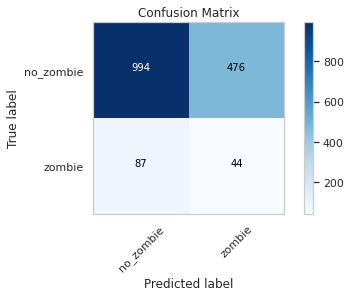

In [103]:
y3_pred = logreg_3.predict(X3_test)
cm3 = confusion_matrix(y3_test, y3_pred)
plot_confusion_matrix(cm=cm3, classes=cm_plot_labels, title='Confusion Matrix')

**Resto de métricas**

              precision    recall  f1-score   support

           0       0.92      0.68      0.78      1470
           1       0.08      0.34      0.14       131

    accuracy                           0.65      1601
   macro avg       0.50      0.51      0.46      1601
weighted avg       0.85      0.65      0.73      1601



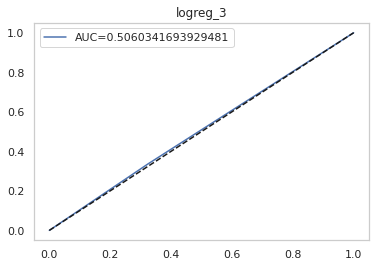

In [104]:
showMetrics(y3_test, y3_pred, 'logreg_3')